In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
%matplotlib inline
import ReadingFile
import PreprocessData

def clear(key_params=[]):
    X, y = ReadingFile.read_csv('TRAIN_CORPUS.csv')
    X = PreprocessData.prepare_data(X, mode='save', key_features=key_params)
    return X, y

def check_score(X, y, clf, verbose=0):    
    predicted = cross_val_predict(clf, X, y, cv=10, verbose=verbose)
    return metrics.accuracy_score(y, predicted)

In [2]:
X, y = clear()
svm_clf = SVC(kernel='linear')
svm_clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [3]:
# test feature transformation

scores = []

X, y = ReadingFile.read_csv('TRAIN_CORPUS.csv')
scores.append(check_score(X, y, svm_clf))

X, y = ReadingFile.read_csv('TRAIN_CORPUS.csv')
scores.append(check_score(PreprocessData.prepare_features(X), y, svm_clf))

X, y = ReadingFile.read_csv('TRAIN_CORPUS.csv')
scores.append(check_score(PreprocessData.prepare_data(X, mode='save'), y, svm_clf))

scores

[0.80000000000000004, 0.89677419354838706, 0.91612903225806452]

In [6]:
# test feature importances

from sklearn.feature_selection import RFE
scores = []

for i in xrange(18):
    X, y = clear()
    estimator = SVC(kernel='linear')
    selector = RFE(estimator, i+1)
    selector = selector.fit(X, y)
    feature_nums = []
    for j in xrange(len(selector.ranking_)):
        if selector.ranking_[j] == 1:
            feature_nums.append(j)
    X1 = np.array([[X[g][j] for j in feature_nums] for g in xrange(len(X))])
    scores.append(check_score(X1, y, svm_clf))

max_num = 1
for i in xrange(len(scores)):
    print(i+1, scores[i])
    if scores[i] >= scores[max_num - 1]:
        max_num = i + 1

(1, 0.80645161290322576)
(2, 0.80645161290322576)
(3, 0.85806451612903223)
(4, 0.87096774193548387)
(5, 0.9096774193548387)
(6, 0.9096774193548387)
(7, 0.9096774193548387)
(8, 0.92903225806451617)
(9, 0.92258064516129035)
(10, 0.92258064516129035)
(11, 0.92903225806451617)
(12, 0.91612903225806452)
(13, 0.92258064516129035)
(14, 0.90322580645161288)
(15, 0.89032258064516134)
(16, 0.90322580645161288)
(17, 0.91612903225806452)
(18, 0.91612903225806452)


In [7]:
# getting unimportant features

feature_names = [ 'verb_in_name', 'template', 'is_inherited','constructors', 'total_methods',
                  'nonpublic_methods', 'static_methods', 'biggest_method_size',
                  'total_fields', 'nonpublic_fields', 'fields_class_refs', 'getters', 'setters',
                  'CG_edges', 'CG_no_entrance_vertexes', 'CG_no_out_vertexes',
                  'CG_comp_num', 'CG_strong_comp_num']
X, y = clear()
estimator = SVC(kernel='linear')
selector = RFE(estimator, max_num)
selector = selector.fit(X, y)
feature_nums = []
for i in xrange(len(selector.ranking_)):
    if selector.ranking_[i] == 1:
        feature_nums.append(i)
    print(selector.ranking_[i], feature_names[i])
feature_nums

(6, 'verb_in_name')
(8, 'template')
(7, 'is_inherited')
(1, 'constructors')
(1, 'total_methods')
(1, 'nonpublic_methods')
(1, 'static_methods')
(1, 'biggest_method_size')
(1, 'total_fields')
(4, 'nonpublic_fields')
(3, 'fields_class_refs')
(1, 'getters')
(2, 'setters')
(1, 'CG_edges')
(5, 'CG_no_entrance_vertexes')
(1, 'CG_no_out_vertexes')
(1, 'CG_comp_num')
(1, 'CG_strong_comp_num')


[3, 4, 5, 6, 7, 8, 11, 13, 15, 16, 17]

In [8]:
# cutting out unimportant features

X, y = clear()
XX = np.array([[X[g][j] for j in feature_nums] for g in xrange(len(X))])
svm_clf = SVC(kernel='linear')
check_score(XX, y, svm_clf)

0.92903225806451617

In [9]:
# тест других параметров алгоритма обучения

X, y = clear(key_params=feature_nums)
clfs = []
clfs.append(SVC(kernel='linear'))
for clf in clfs:
    print check_score(X, y, clf)

0.929032258065


In [10]:
def learn_stat(X, y, C):
    
    clf = SVC(kernel='linear', C=C)
    score = check_score(X, y, clf)
    predicted = cross_val_predict(clf, X, y, cv=10)
    X_score = metrics.accuracy_score(y, predicted)
    return X_score

In [11]:
def plot_stat(X, y, minC, maxC, steps, file_path):
    from matplotlib.pyplot import savefig
    opt_C = 0.001
    max_score = 0.0
    array = np.logspace(np.log10(minC), np.log10(maxC), steps)
    scores = np.zeros(len(array))
    vectors = np.zeros(len(array))
    for i in xrange(len(array)):
        scores[i] = learn_stat(X, y, array[i])
        if scores[i] > max_score:
            max_score = scores[i]
            opt_C = array[i]
            
    pl.title("SVC Score on C for linear")  
    pl.xscale('log')
    pl.xlabel('C-value (log-scale)')
    pl.plot(array, scores, label = 'X', color = 'r')
    
    pl.savefig(file_path)
    
    return opt_C, max_score

In [12]:
X, y = clear(key_params=feature_nums)

(1.5556761439304723, 0.9419354838709677)


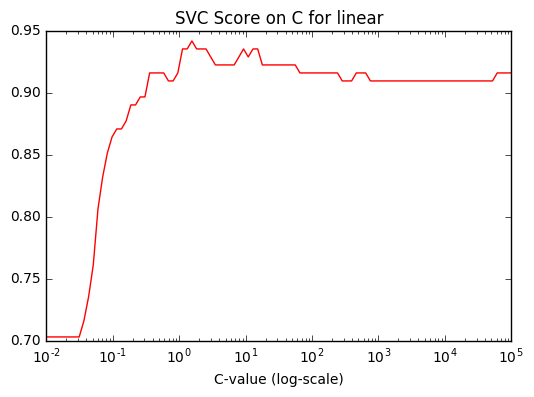

In [13]:
opt_C, max_score = plot_stat(X, y, 0.01, 100000, 100, 'SVC_C1.png')
print(opt_C, max_score)

(1.4174741629268053, 0.9419354838709677)


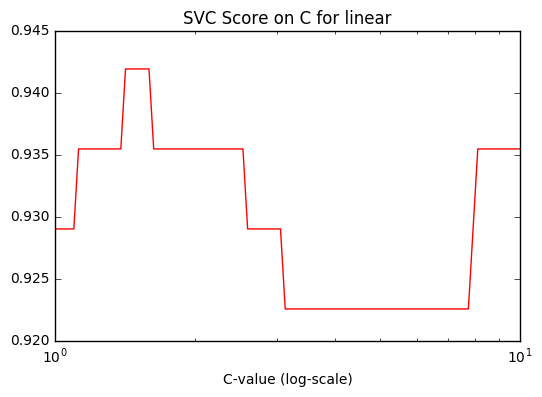

In [14]:
# Здесь смотрим на предыдущий график и уменьшаем интересующий нас диапазон параметра C
# в целях достижения большей точности

opt_C, max_score = plot_stat(X, y, 1, 10, 100, 'SVC_C2.png')
print(opt_C, max_score)

(2.915053062825177, 0.92258064516129035)


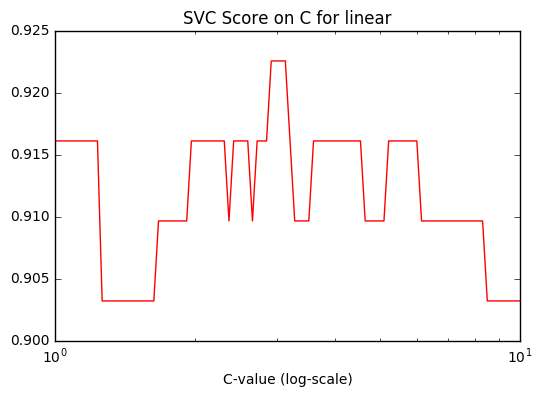

In [16]:
X, y = clear(key_params=[])
opt_C_full, max_score_full = plot_stat(X, y, 1, 10, 100, 'SVC_C0_full.png')
print(opt_C_full, max_score_full)

In [17]:
X, y = clear(key_params=feature_nums)
svm_clf = SVC(kernel='linear', C=opt_C)
svm_clf.fit(X, y)
coef = svm_clf.coef_
from sklearn.externals import joblib
joblib.dump(svm_clf, 'SVM_params.pkl') 

['SVM_params.pkl']

In [18]:
X, y = clear(key_params=[])
svm_clf = SVC(kernel='linear', C=opt_C_full)
svm_clf.fit(X, y)
from sklearn.externals import joblib
joblib.dump(svm_clf, 'SVM_full_params.pkl') 

['SVM_full_params.pkl']

In [21]:
print 'SVC с линейным ядром'
print 'Для полного набора признаков:'
print 'C =', opt_C_full
print 'Точность =', max_score_full

SVC с линейным ядром
Для полного набора признаков:
C = 2.91505306283
Точность = 0.922580645161


In [22]:
print 'SVC с линейным ядром'
print 'Для оптимального набора признаков:'
print 'C = ', opt_C
print 'Точность = ', max_score

SVC с линейным ядром
Для оптимального набора признаков:
C =  1.41747416293
Точность =  0.941935483871
